In [166]:
import cv2
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

In [167]:
# Matplotlib figure size to have large enough image plotting
#FIGURE_SIZE = (12, 6)
FIGURE_SIZE = (12, 18)

def plot_bgr(img):
    """ A helper for plotting a BGR image with matplotlib """
    plt.figure(figsize=FIGURE_SIZE)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
def plot_gray(gray):
    """ A helper for plotting a grayscale image with matplotlib """
    plt.figure(figsize=FIGURE_SIZE)
    plt.imshow(gray, cmap='gray')

In [168]:
IMG_PATH = "/home/rattus/Free/Udacity/CarND-Capstone/imgs/traffic/samples"
images = os.listdir(IMG_PATH)
images.sort()

In [169]:
SAT_THR = 160
VAL_THR = 200

In [170]:
def clamp_saturation(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    blue = img[:,:,0]
    blue_mean = blue.mean()
    sat = hsv[:,:,1]
    val = hsv[:,:,2]
    mask = np.zeros(sat.shape)
    mask[sat > SAT_THR] += 50
    mask[val > VAL_THR] += 50
    mask[mask < 100] = 0
    mask[mask >= 100] = 1
    return mask.astype(np.uint8)

In [171]:
def detect_state(masked_light):
    red_mean = masked_light[:,:,2].mean()
    green_mean = masked_light[:,:,1].mean()
    blue_mean = masked_light[:,:,0].mean()
    
    red_green_diff_ratio = (red_mean + green_mean) / (abs(red_mean - green_mean)*2. + 0.01)
    non_blue_ratio = max(0., (red_mean + green_mean) - (2. * blue_mean))
    print("r-g, nonbl ", red_green_diff_ratio, non_blue_ratio)
    yellow_mean = red_green_diff_ratio * non_blue_ratio
    # States: 0 - red, 1 - yellow, 2 - green, 4 - Unknown
    print("R, G, B, Y : {:0.2f}, {:0.2f}, {:0.2f}, {:0.2f}"
          .format(red_mean, green_mean, blue_mean, yellow_mean))
    indices = np.array([red_mean, yellow_mean, green_mean])
    if (indices.max() < 0.15 or indices.max() < blue_mean):
        return 4
    return indices.argmax()

In [188]:
def draw_state(image, state):
    font = cv2.FONT_HERSHEY_SIMPLEX 
    states = ["Red", "Yellow", "Green", "Unknown", "Unknown"]
    state_str = states[state]

    org = (5, image.shape[0] - 5) 
    fontScale = 0.7
    color = (250, 250, 250) 
    thickness = 1

    result = cv2.putText(image, state_str, org, font,
                   fontScale, color, thickness, cv2.LINE_AA) 
    return result

r-g, nonbl  0.7029737609329447 0.5653333333333335
R, G, B, Y : 0.69, 0.12, 0.12, 0.40
r-g, nonbl  0.7156475238316671 0.22680000000000003
R, G, B, Y : 0.06, 0.35, 0.09, 0.16
r-g, nonbl  30.192771084337366 0.27213333333333334
R, G, B, Y : 0.17, 0.17, 0.03, 8.22
r-g, nonbl  0.6682397357243982 0.1364
R, G, B, Y : 0.16, 0.03, 0.03, 0.09
r-g, nonbl  57.482758620689985 0.5325333333333334
R, G, B, Y : 0.33, 0.33, 0.07, 30.61
r-g, nonbl  0.0 0.0
R, G, B, Y : 0.00, 0.00, 0.00, 0.00
r-g, nonbl  0.0 0.0
R, G, B, Y : 0.00, 0.00, 0.00, 0.00
r-g, nonbl  0.6711015456857758 0.2617333333333334
R, G, B, Y : 0.06, 0.40, 0.10, 0.18
r-g, nonbl  0.5789833015674337 1.6426666666666663
R, G, B, Y : 2.53, 0.19, 0.54, 0.95
r-g, nonbl  0.7061696045736063 0.0
R, G, B, Y : 0.06, 0.34, 0.26, 0.00
r-g, nonbl  0.8119593313803205 0.06213333333333315
R, G, B, Y : 0.61, 2.54, 1.54, 0.05
r-g, nonbl  5.009354536950422 0.0
R, G, B, Y : 0.32, 0.39, 0.65, 0.00
r-g, nonbl  4.338300220750551 0.3822
R, G, B, Y : 0.29, 0.23, 0.07,

True

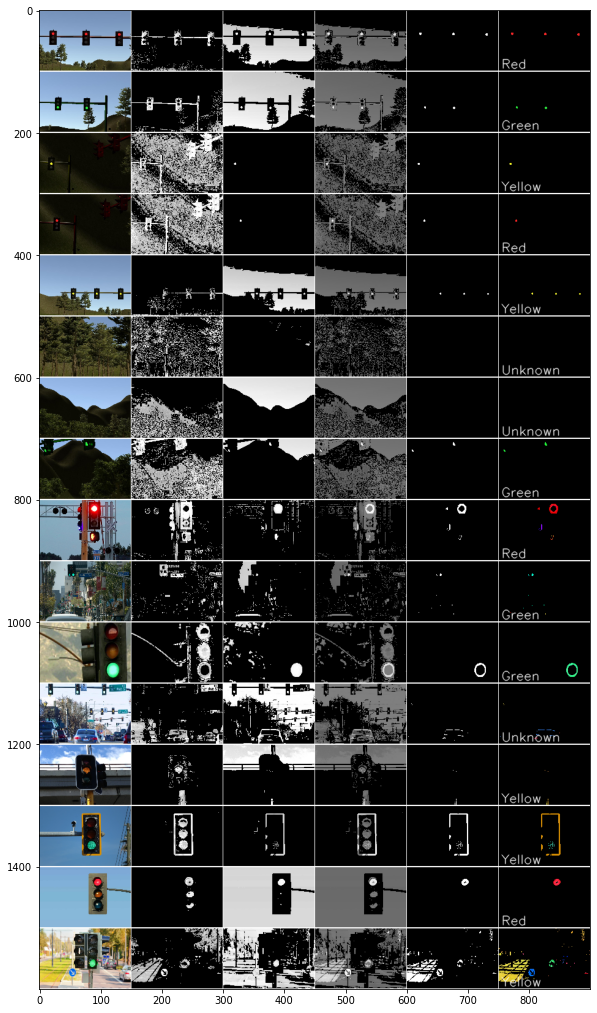

In [189]:
idx = 13
illustrations = []
for i in range(len(images)):
#for i in range(idx, idx+1):
    img = cv2.resize(cv2.imread(os.path.join(IMG_PATH, images[i])), (150,100))
    
    mask = clamp_saturation(img)
    
    lights_only = np.zeros(img.shape)
    lights_only = cv2.bitwise_and(img, img, mask=mask)
    state = detect_state(lights_only)

    # Illustration generation
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    sat = hsv[:,:,1]
    val = hsv[:,:,2]
    sat[sat < SAT_THR] = 0
    val[val < VAL_THR] = 0
    sat_val_sum = (sat//2)+(val//2)
    mask_gray = mask * 255
    # Vertical white border lines
    lights_only[:,0,:] = 255
    mask[:,0] = 255
    sat[:,0] = 255
    val[:,0] = 255
    sat_val_sum[:,0] = 255
    mask_gray[:,0] = 255
    
    gray_parts = np.expand_dims(
                    np.concatenate(
                        (sat, val, sat_val_sum, mask_gray), axis=1),
                 2)
    gray_parts_as_bgr = np.concatenate((gray_parts,gray_parts,gray_parts), axis=2)
    all_stripe = np.concatenate(
        (img, gray_parts_as_bgr, draw_state(lights_only, state)),
        axis=1)
    # Horizontal white border lines
    all_stripe[0,:,:] = 255
    all_stripe[-1,:,:] = 255
    illustrations.append(all_stripe)

illustrations = np.concatenate(np.array(illustrations), axis = 0)
plot_bgr(illustrations)
cv2.imwrite("illustrations.jpg", illustrations)